# Analysis and prediction of Covid-19 data using Python

## 1. Récupération de bases de données

Récuperer les données covid en temps réel au format JSON grâce au site "Our world in data" qui met à disposition toutes ces données. 
Voici un projet Github expliquant comment utiliser l'intégralité des données Covid mises à disposistion : https://github.com/owid/covid-19-data/tree/master/public/data

In [3]:
import requests
url = "https://covid.ourworldindata.org/data/owid-covid-data.json"
resp = requests.get(url)
print(f"Response status code : {resp.status_code}")

Response status code : 200


Une fois les données récupérées : status_code = 200, nous pouvons les parcourir. 
Le fichier renvoyé est au format JSON.

En fonction des jours et des pays, les données récoltées ne sont pas les mêmes, voyons donc quelles sont les différentes données mises à disposition pour la suisse 
Le code ISO pour la suisse est CHE.

In [4]:
import json
json_input = json.loads(resp.content)

iso = "CHE"
for key, value in json_input[iso].items(): 
	if key != "data":
		print(f"{key} : {value}")

continent : Europe
location : Switzerland
population : 8715494.0
population_density : 214.243
median_age : 43.1
aged_65_older : 18.436
aged_70_older : 12.644
gdp_per_capita : 57410.166
cardiovasc_death_rate : 99.739
diabetes_prevalence : 5.59
female_smokers : 22.6
male_smokers : 28.9
hospital_beds_per_thousand : 4.53
life_expectancy : 83.78
human_development_index : 0.955


In [5]:
import pandas

data = json_input[iso]["data"]
df = pandas.DataFrame(data)
print(df.columns)

print(f"\nData gathered on {len(df)} days, from {df['date'][0]} to {df['date'][len(df) - 1]}.")

Index(['date', 'total_cases', 'new_cases', 'total_cases_per_million',
       'new_cases_per_million', 'stringency_index', 'new_cases_smoothed',
       'new_deaths_smoothed', 'new_cases_smoothed_per_million',
       'new_deaths_smoothed_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'excess_mortality_cumulative_per_million',
       'total_deaths', 'new_deaths', 'total_deaths_per_million',
       'new_deaths_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand', 'positive_rate',
       'tests_per_case', 'tests_units', 'new_tests_smoothed',
       'new_tests_smoothed_per_thousand', 'total_vaccinations',
       'people_vaccinated', 'total_vaccinations_per_hundred',
       'people

Voici ci-dessus toutes les informations disponibles pour la Suisse.

Voyons ce que donne un graphique sur l'évolution du nombre de nouveaux cas covid chaque jour depuis le début de la pandémie.

<ipython-input-18-b8e122faa0da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_df['date'] = pandas.to_datetime(cases_df['date']) # Transforming Object into datetime


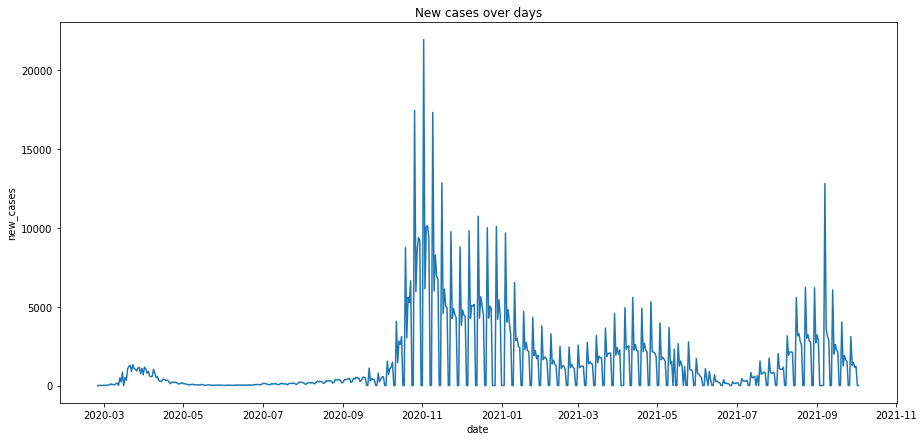

In [18]:
import seaborn 
from matplotlib import pyplot as pyplot

cases_df = df[['date', 'new_cases']] # Collect only date and new_cases on each days
cases_df['date'] = pandas.to_datetime(cases_df['date']) # Transforming Object into datetime 

pyplot.figure(figsize=(15, 7)) # To set the output size
cases_chart = seaborn.lineplot(
    x="date",
    y="new_cases",
    data=cases_df
).set_title("New cases over days")
pyplot.show()